# Introduction to Python and the GraphBLAS

## by Michel Pelletier

https://github.com/Graphegon/pygraphblas


[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Graphegon/pygraphblas/v4.0.3?filepath=pygraphblas%2Fdemo%2FIntroduction-to-GraphBLAS-with-Python.ipynb)


In [1]:
from pygraphblas import *
from pygraphblas.gviz import *

print('Hello this is live!!!!')

Hello this is live!!!!


# The Graph Matrix Duality

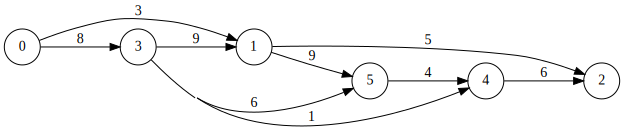

In [2]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 3, 4, 1, 5],
    [1, 3, 2, 1, 4, 5, 2, 5, 4], 
    [3, 8, 5, 9, 1, 6, 6, 9, 4])
draw(A)

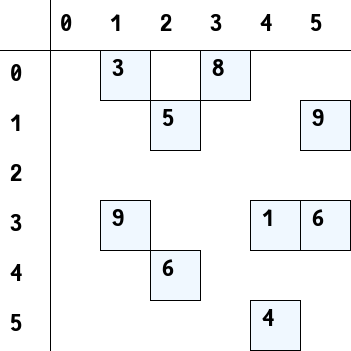

In [3]:
draw_matrix(A, scale=50, labels=True)

# Matrix Multiplication is Breadth First Search

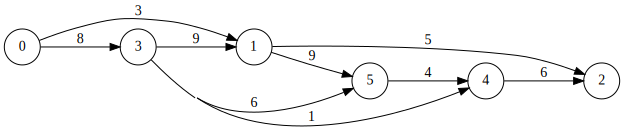

In [4]:
draw(A)

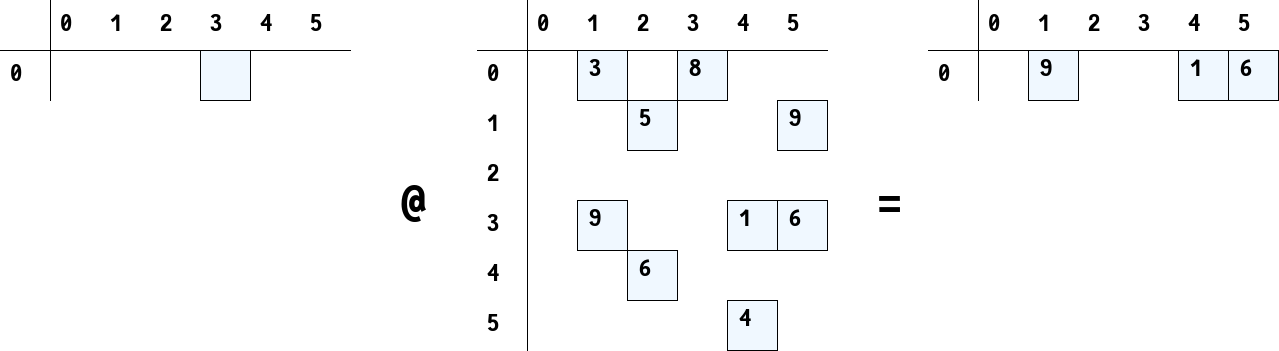

In [5]:
v = Vector.from_lists([3], [True], A.nrows)

y = v @ A
draw_matrix_op(v, '@', A, y, scale=50, labels=True, column=False)

# Union

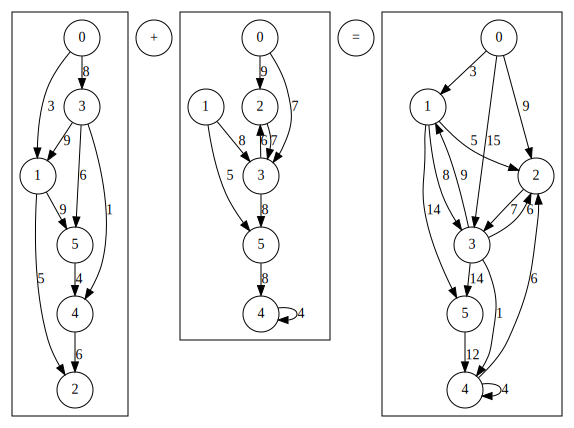

In [41]:
B = Matrix.from_lists([0, 0, 1, 3, 3, 4, 1, 5, 2],[2, 3, 3, 2, 5, 4, 5, 4, 3],[9, 7, 8, 6, 8, 4, 5, 8, 7],)

C = A + B
draw_graph_op(A, '+', B, C)

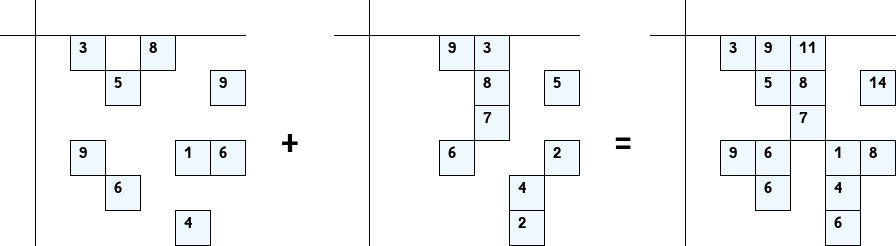

In [35]:
C = A + B
draw_matrix_op(A, '+', B, C, scale=35)

# Intersection

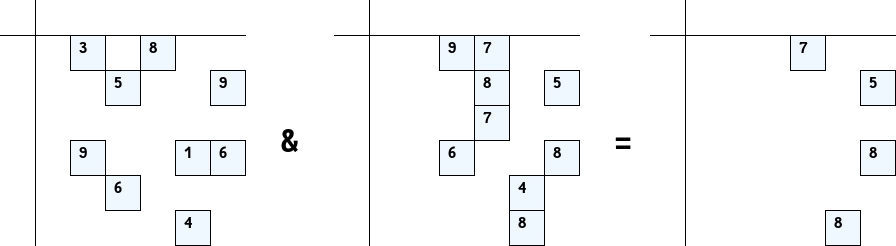

In [42]:
C = A & B
draw_matrix_op(A, '&', B, C, scale=35)

# Using an Operator

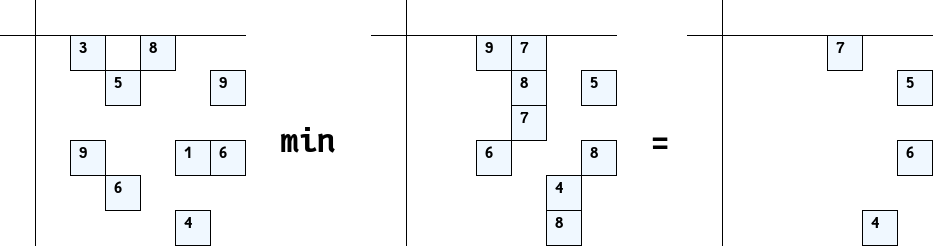

In [43]:
with binaryop.MIN:
    C = A & B

draw_matrix_op(A, 'min', B, C, scale=35)

# Vector Matrix Multiplication

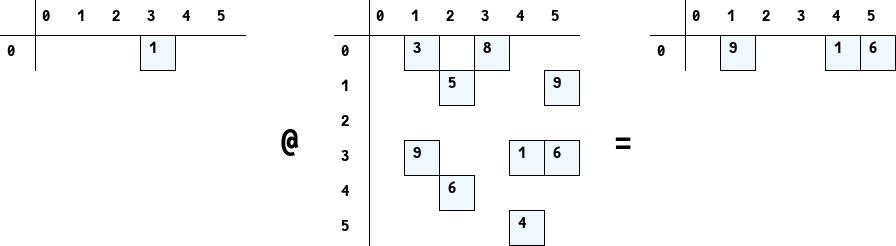

In [10]:
v = Vector.from_lists([3],[1], A.nrows)

y = v @ A
draw_matrix_op(v, '@', A, y, scale=35, labels=True, column=False)

# Matrix Vector Multiplication

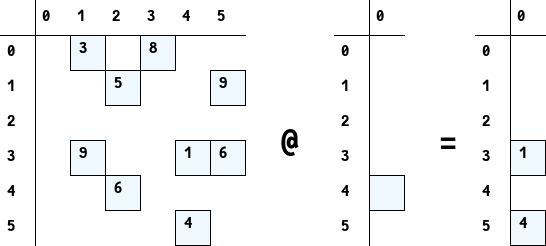

In [11]:
v = Vector.from_lists([4],[True], A.nrows)

y = A @ v
draw_matrix_op(A, '@', v, y, scale=35, labels=True)

# Matrix Matrix Multiplication

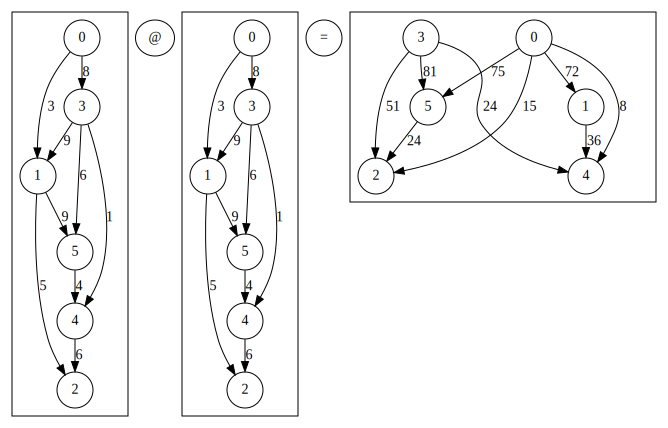

In [12]:
draw_graph_op(A, '@', A, A @ A)

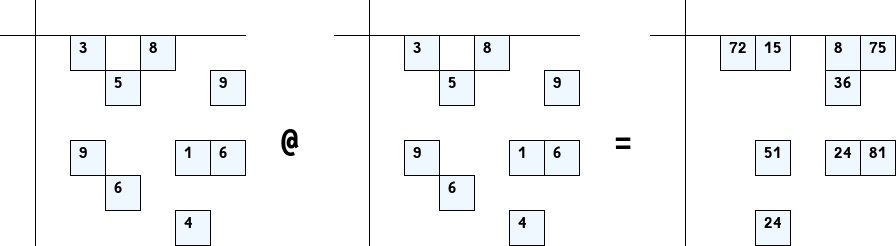

In [13]:
draw_matrix_op(A, '@', A, A @ A, scale=35)

# Using a Semiring

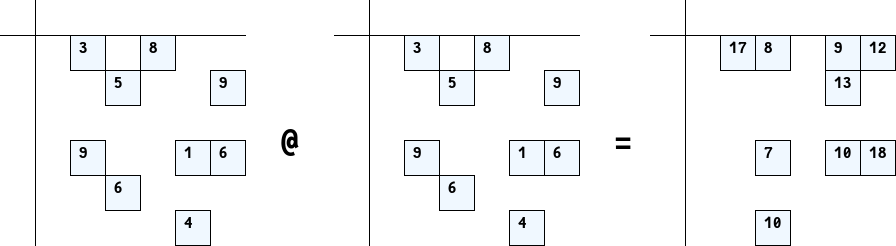

In [14]:
with semiring.MIN_PLUS:
    g = draw_matrix_op(A, '@', A, A @ A, scale=35)
g

# Breadth First Search

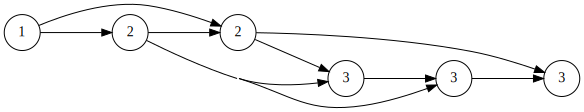

In [15]:
def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.sparse(UINT8, matrix.nrows)   # the result vector
    q = Vector.sparse(BOOL, matrix.nrows)    # a vector to keep track of known nodes
    
    q[start] = True
    not_done = True
    level = 1
    
    while not_done and level <= matrix.nrows:
        v.assign_scalar(level, mask=q)        # Assign the current level to known (q) nodes in v
        q = v.vxm(matrix, 
                  mask=v, 
                  desc=descriptor.C)         # compliment the mask only find the next unknown nodes
        not_done = q.reduce_bool()              # is q full?
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

# Shortest Path Length

In [16]:
def shortest_path_length(matrix, start):
    v = Vector.sparse(matrix.type, matrix.nrows)
    v[start] = 0

    with semiring.MIN_PLUS, binaryop.Accum(binaryop.MIN):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

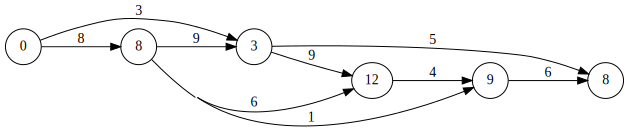

In [17]:
    draw(A, label_vector=shortest_path_length(A, 0))

# PageRank

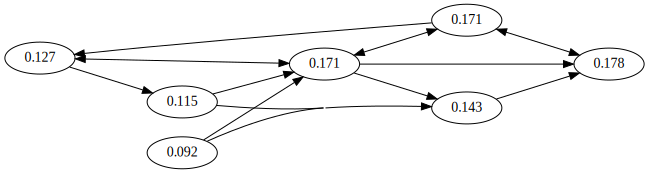

In [18]:
def pagerank(A, damping_factor, itermax):
    n = A.nrows
    d_out = A.reduce_vector()
    pr = Vector.sparse(FP32, n)
    pr[:] = 1.0/n
    teleport = (1 - damping_factor) / n
    for i in range(itermax):
        importance_vec = pr / d_out
        with binaryop.Accum(binaryop.TIMES):
            importance_vec[:] = damping_factor
        importance_vec = A.transpose() @ importance_vec
        dangling_vec = pr[d_out]
        dangling_sum = dangling_vec.reduce_int() * (damping_factor / n)
        pr[:] = (teleport + dangling_sum)
        pr = pr + importance_vec
    return pr


M = Matrix.random(FP32, 7, 7, 30, no_diagonal=True, make_pattern=True, seed=42)

pr = pagerank(M, 0.35, 3)
draw(M, label_vector=pr, size_vector=pr, show_weight=False, label_width=5)

# Sparse Deep Neural Networks

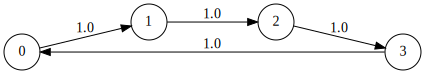

In [19]:
def permutation_matrix(size):
    P = Matrix.sparse(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

draw(permutation_matrix(4))

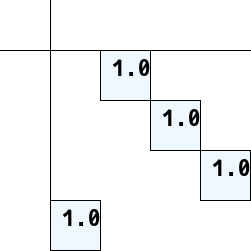

In [20]:
draw_matrix(permutation_matrix(4), scale=50)

In [21]:
from functools import reduce
from operator import attrgetter, mul

def hypergraph(mt):
    size = sum(map(attrgetter('nrows'), mt)) + mt[0].nrows
    r = Matrix.sparse(FP32, size, size)
    ioffset = 0
    joffset = 0
    for m in mt:
        joffset += m.nrows
        for c, (i, j, k) in enumerate(m):
            r[i + ioffset, j + joffset] = k
        ioffset += m.nrows
    return r

def mixed_topo_radix(topos):
    sizes = [reduce(mul, x) for x in topos]
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)
    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.sparse(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

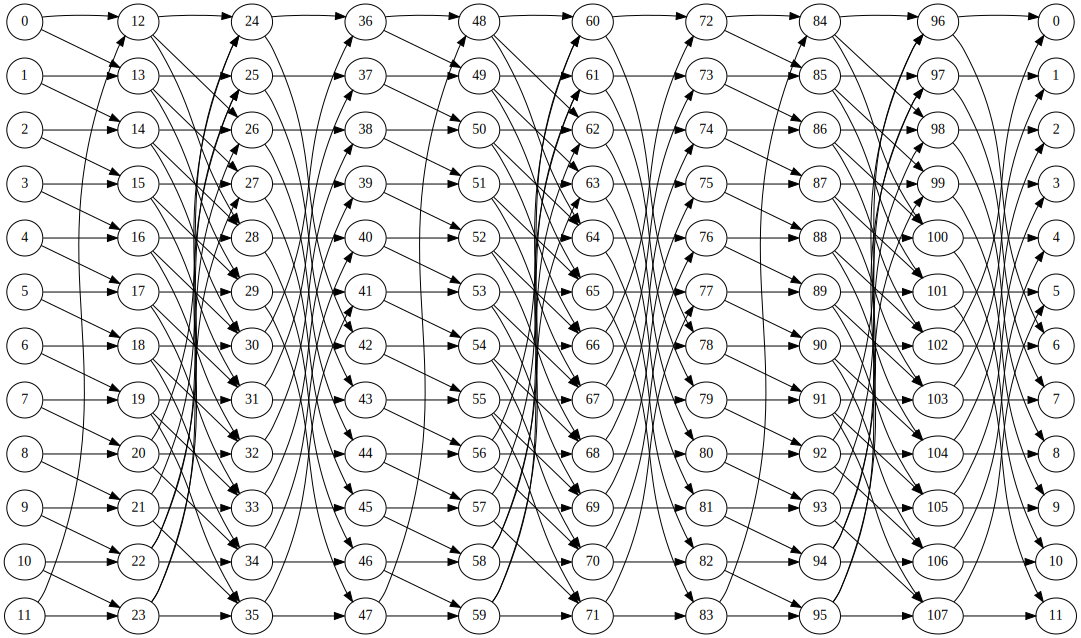

In [22]:
mt = mixed_topo_radix([[2,3,2],[2,3,2],[2,3,2]])
draw_layers(mt)

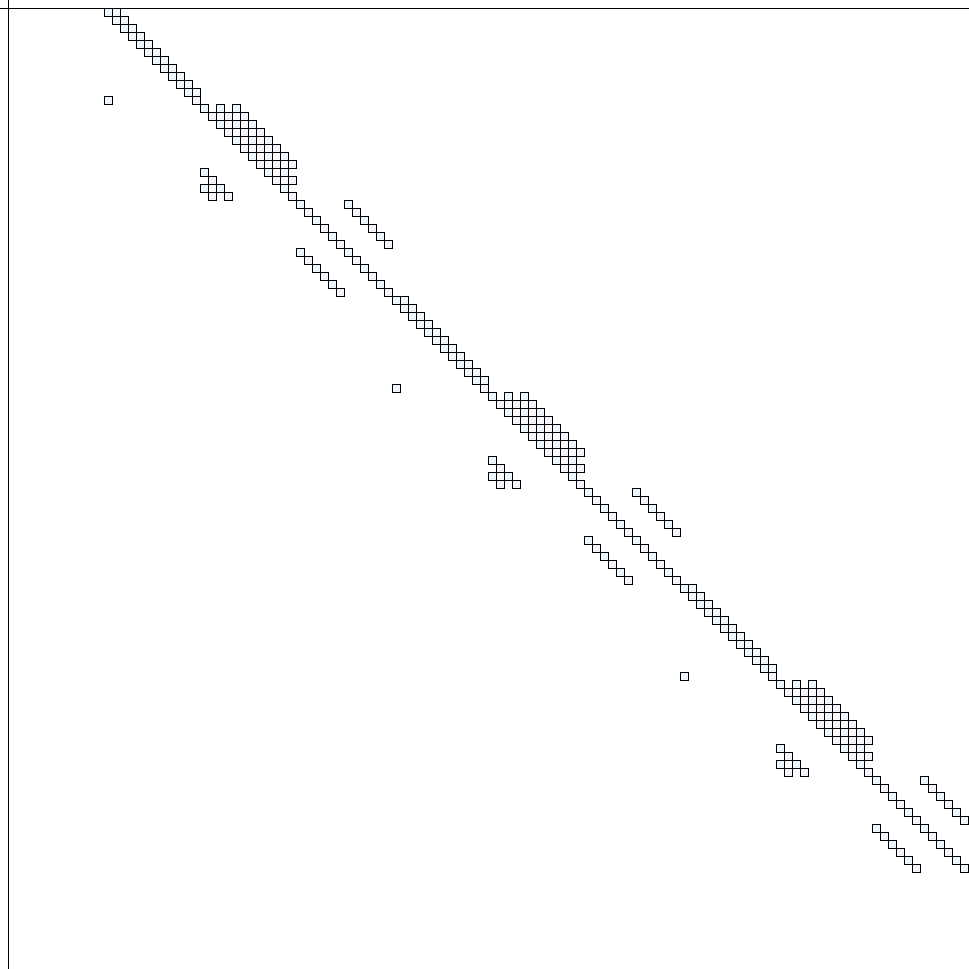

In [23]:
draw_matrix(hypergraph(mt).pattern(), scale=8)

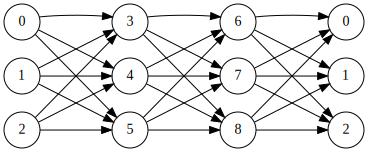

In [24]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

d = ddnn([3,3,3,3])
draw_layers(d)

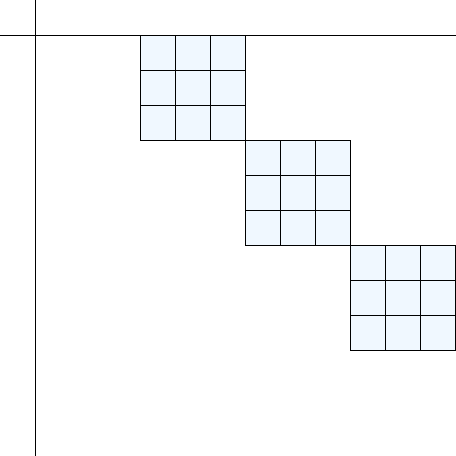

In [25]:
draw_matrix(hypergraph(d).pattern(), scale=35)

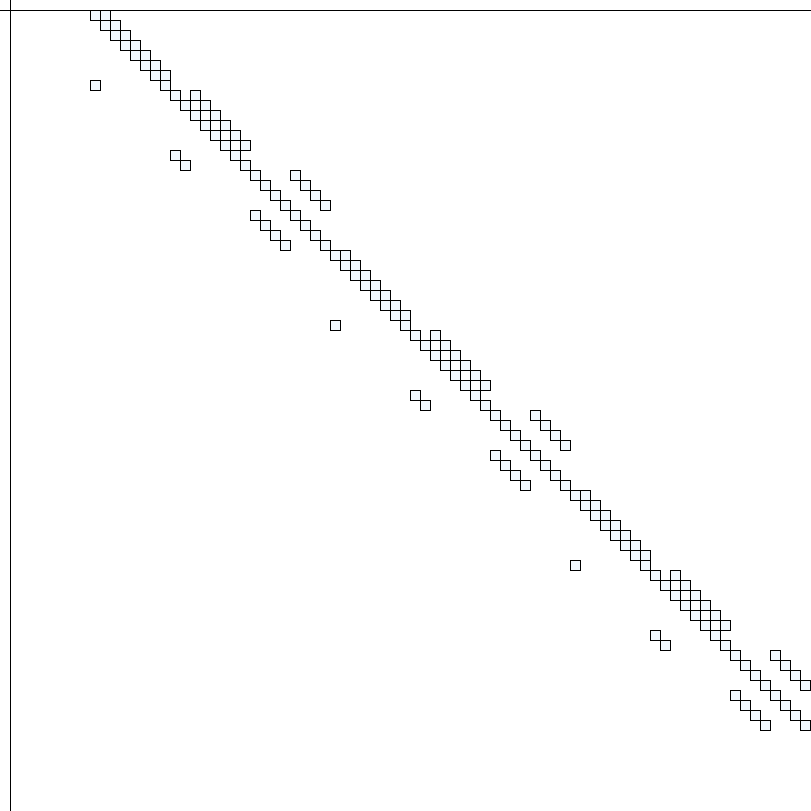

In [26]:
def radixnet(topos, spec):
    return [d.kronecker(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]

spec = [[2,2,2], [2,2,2], [2,2,2]]
hp = hypergraph(mixed_topo_radix(spec))
draw_matrix(hp.pattern(), scale=10) 